In [21]:
%matplotlib inline
import numpy as np
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import math 
import pandas as pd
from numpy import linalg as LA
from sympy import * 
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
# import pygal
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
#import mypy
import math
import pandas as pd
from scipy.optimize import curve_fit
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get

In [22]:
# Orthonormal vectors n, u, <n,u>=0
r = 2.5               # Radius
C = np.array([3,3,4])    # Center
# theta = 45/180*np.pi     # Azimuth
# phi   = -30/180*np.pi    # Zenith
theta = 30/180*np.pi     # Azimuth
phi   = 30/180*np.pi    # Zenith
n = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])
u = np.array([-np.sin(phi), np.cos(phi), 0])
size = 500
t = np.linspace(0, 0.5*np.pi, size)
# P(t) = r*cos(t)*u + r*sin(t)*(n x u) + C
P = r*np.cos(t)[:,np.newaxis]*u + r*np.sin(t)[:,np.newaxis]*np.cross(n,u)

x0 = P[:,0]
y0 = P[:,1]
z0 = P[:,2]

# x = P[:,0]
# y = P[:,1]
# z = P[:,2]

In [23]:
# With Noise
Prad = []
for _ in range(0,10):
    P_noise = P +  np.random.normal(size=P.shape) * 0.1
    x = P_noise[:,0]
    y = P_noise[:,1]
    z = P_noise[:,2]

    P_rad = np.sqrt(x**2 + y**2)
    # print("P radius: ", np.mean(P_rad))

    # Sphere input size
    sphere_size = np.size(x)

    # Array lengths
    leng = len(x)

    #%%
    # Create linear equation

    # Design Matrices
    mat_A = np.ones((3,3))
    mat_B = np.ones((3,1))

    # Update matrices
    # Initialize terms
    a_00 = x[0] ** 2
    a_01 = x[0] * y[0]
    a_02 = x[0]
    a_10 = x[0] * y[0]
    a_11 = y[0] ** 2
    a_12 = y[0]
    a_20 = x[0]
    a_21 = y[0]
    b_0 = x[0] * z[0]
    b_1 = y[0] * z[0]
    b_2 = z[0]
    for i in range(0,len(x)):
        mat_A[0][0] = a_00 + x[i] ** 2
        a_00 = mat_A[0][0]
        mat_A[0][1] = a_01 + (x[i] * y[i])
        a_01 = mat_A[0][1]
        mat_A[0][2] = a_02 + x[i]
        a_02 = mat_A[0][2]
        mat_A[1][0] = a_10 + (x[i] * y[i])
        a_10 = mat_A[1][0]
        mat_A[1][1] = a_11 + (y[i] ** 2)
        a_11 = mat_A[1][1]
        mat_A[1][2] = a_12 + y[i]
        a_12 = mat_A[1][2]
        mat_A[2][0] = a_20 + (x[i])
        a_20 = mat_A[2][0]
        mat_A[2][1] = a_21 + (y[i])
        a_21 = mat_A[2][1]
        mat_A[2][2] = len(x)
        mat_B[0][0] = b_0 + (x[i] * z[i])
        b_0 = mat_B[0][0]
        mat_B[1][0] = b_1 + (y[i] * z[i])
        b_1 = mat_B[1][0]
        mat_B[2][0] = b_2 + (z[i])
        b_2 = mat_B[2][0]

    #%%
    # Coefficients
    # Solve for coefficients
    # lss = mat_B * np.linalg.pinv(mat_A)
    lss = np.matmul(np.linalg.pinv(mat_A),mat_B)
    # lss = mat_B * np.linalg.pinv(mat_A)
    print(lss)
    A = lss[0]
    B = lss[1]
    C = lss[2]

    X, Y = np.meshgrid(x, y)
    zz_mesh = A*X + B*Y + C
    zz_0 = A*x + B*y + C

    #%%
    # Circle Plane
    M_0 = 10
    M_fac = 5
    M = M_0 * M_fac
    N = size
    R1 = 0
    R2 = np.mean(P_rad)
    nR = np.linspace(R1, R2, M)
    nT = np.linspace(0, 2*np.pi,N)
    R,T = np.meshgrid(nR, nT)

    # Radius
    print("Radius: ", np.max(R))
    # Diameter
    print("R std dev: ", np.max(R) - (np.min(R)))
    # Radius approx 2
    rad_0 = (np.max(R) - np.min(R)) / 2
    print('Radius Approx 2: ', rad_0)

    X1 = R * np.cos(T)
    Y1 = R * np.sin(T)
    Z = np.ones((len(T),1))
    row, col = X.shape

    zz_mesh_circ = A*X1 + B*Y1 + C

    # Calculate Radius
    radii = []
    for i in range(0,M):
        rad_mesh = np.sqrt(X1[0,i] ** 2 + Y1[0,i]**2)
        radii.append(rad_mesh)
    max_rad = radii.index(max(radii))

    #Error
    err_r_0 = (r*np.ones((M))-radii)
    err_r_sq = np.square(err_r_0)
    err_r = err_r_sq.tolist()
    min_err = err_r.index(min(err_r))
#     print("Minimum Error: ", err_r)
#     print("Minimum Error Index: ", min_err)

    #%%
    # Setup circle equations

    # Angle: theta
    theta = np.linspace(0, 2*np.pi)

    # Coordinates
    # Version 1
    # Middle index
    mid_ind = int(size/2)
    rad = np.sqrt(x[mid_ind] ** 2 + y[mid_ind] ** 2)
    x_c = rad * np.cos(theta)
    y_c = rad * np.sin(theta)
    Prad.append(rad)
print("Radius Approx: ", rad)
print("List of Radii: ", Prad)



[[-0.423]
 [-0.298]
 [ 0.148]]
Radius:  2.3442754936783947
R std dev:  2.3442754936783947
Radius Approx 2:  1.1721377468391974
[[-0.405]
 [-0.305]
 [ 0.209]]
Radius:  2.329360163340459
R std dev:  2.329360163340459
Radius Approx 2:  1.1646800816702294
[[-0.379]
 [-0.307]
 [ 0.259]]
Radius:  2.3350417548751605
R std dev:  2.3350417548751605
Radius Approx 2:  1.1675208774375803
[[-0.374]
 [-0.305]
 [ 0.252]]
Radius:  2.342728441889317
R std dev:  2.342728441889317
Radius Approx 2:  1.1713642209446584
[[-0.36 ]
 [-0.313]
 [ 0.291]]
Radius:  2.3382408127643246
R std dev:  2.3382408127643246
Radius Approx 2:  1.1691204063821623
[[-0.376]
 [-0.308]
 [ 0.26 ]]
Radius:  2.3362988588195006
R std dev:  2.3362988588195006
Radius Approx 2:  1.1681494294097503
[[-0.375]
 [-0.309]
 [ 0.264]]
Radius:  2.344926767356451
R std dev:  2.344926767356451
Radius Approx 2:  1.1724633836782254
[[-0.437]
 [-0.306]
 [ 0.135]]
Radius:  2.340926495752792
R std dev:  2.340926495752792
Radius Approx 2:  1.170463247

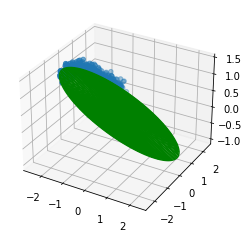

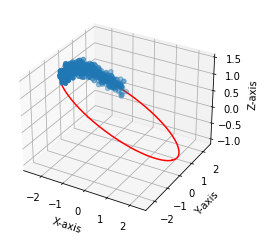

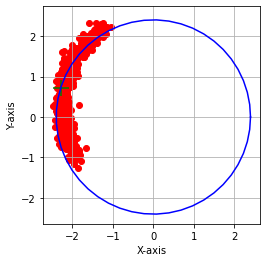

In [24]:
#%%
# Plots
plot4 = plt.figure(4)
ax = plt.axes(projection = '3d')
ax.scatter(x, y, z)
ax.plot_wireframe(X1, Y1, zz_mesh_circ, cmap = 'viridis', edgecolor = 'green')

plot6 = plt.figure(6)
ax = plt.axes(projection = '3d')
ax.scatter(x, y, z)
ax.plot(X1[:,min_err],Y1[:,min_err],zz_mesh_circ[:,min_err], color = 'red')
if min(err_r) < 0:
    ax.plot(X1[:,min_err-M_fac],Y1[:,min_err-M_fac],zz_mesh_circ[:,min_err-M_fac], color = 'blue')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plot7 = plt.figure(7)
sz = int(size/2)
plt.scatter(x,y, color = 'red')
plt.scatter(x[sz], y[sz], marker= "+", color = 'green', s = 250)
plt.plot(x_c, y_c, color = 'b')
plt.grid()
plt.axis('square')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')


# Show plots
plt.show()